In [1]:
!pip install timm

# Import libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter
import timm

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# Set Seeds for Reproducibility

In [3]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [4]:
# Data transformations - Minimal transformations without data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

# Dataset

In [5]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, imaging_type_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths), tissue type (labels), and imaging type columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            imaging_type_encoder (LabelEncoder, optional): Pre-fitted imaging type encoder.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        # Handle imaging type encoding
        if imaging_type_encoder is None:
            self.imaging_type_encoder = LabelEncoder()
            if fit_label_encoder:
                self.imaging_types = self.imaging_type_encoder.fit_transform(self.data['imaging type'])
            else:
                raise ValueError("Must provide imaging_type_encoder or set fit_label_encoder=True")
        else:
            self.imaging_type_encoder = imaging_type_encoder
            self.imaging_types = self.imaging_type_encoder.transform(self.data['imaging type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        imaging_type = self.imaging_types[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long), torch.tensor(imaging_type, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_imaging_type_encoder(self):
        """Return the imaging type encoder for use with other datasets"""
        return self.imaging_type_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [6]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True  
    )
    
    # Get the fitted label encoder and imaging type encoder
    le = train_dataset.get_label_encoder()
    imaging_type_encoder = train_dataset.get_imaging_type_encoder()
    
    # Create validation dataset using the same label encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    # Create test dataset using the same label encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    return train_dataset, val_dataset, test_dataset, le, imaging_type_encoder

# Dataloader

In [7]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [8]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [9]:
train_dataset, val_dataset, test_dataset, label_encoder, imaging_type_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Utility Functions

In [10]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels, _ in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [11]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels, imaging_types in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    imaging_types = imaging_types.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs, imaging_types)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels, imaging_types in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                imaging_types = imaging_types.to(self.device)
                
                outputs = self.model(inputs, imaging_types)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        ax2.set_xlabel('Epoch')

# Model Definitions

In [12]:
class DeiTWithImagingType(nn.Module):
    def __init__(self, base_model, num_features, num_classes=4, num_imaging_types=2, embedding_dim=16):
        super(DeiTWithImagingType, self).__init__()
        self.base_model = base_model
        
        # Imaging type embedding
        self.imaging_type_embedding = nn.Embedding(num_imaging_types, embedding_dim)
        
        # New classifier that takes both image features and imaging type
        self.classifier = nn.Linear(num_features + embedding_dim, num_classes)
        
    def forward(self, x, imaging_type):
        # Get image features
        image_features = self.base_model(x)
        
        # Get imaging type embedding
        imaging_embedding = self.imaging_type_embedding(imaging_type)
        
        # Concatenate features
        combined_features = torch.cat([image_features, imaging_embedding], dim=1)
        
        # Final classification
        output = self.classifier(combined_features)
        return output

def create_deit_model(architecture='deit_base_patch16_224', num_classes=4, num_imaging_types=2, pretrained=True):
    """
    Create DeiT (Data-efficient Image Transformer) model with imaging type input for multi-class classification
    
    Args:
        architecture (str): DeiT architecture - 'deit_tiny_patch16_224', 'deit_small_patch16_224', or 'deit_base_patch16_224'
        num_classes (int): Number of output classes
        num_imaging_types (int): Number of imaging types
        pretrained (bool): Whether to use pretrained weights
    
    Returns:
        model: DeiT model with imaging type support
    """
    if architecture == 'deit_tiny_patch16_224':
        base_model = timm.create_model('deit_tiny_patch16_224', pretrained=pretrained, num_classes=0)
    elif architecture == 'deit_small_patch16_224':
        base_model = timm.create_model('deit_small_patch16_224', pretrained=pretrained, num_classes=0)
    elif architecture == 'deit_base_patch16_224':
        base_model = timm.create_model('deit_base_patch16_224', pretrained=pretrained, num_classes=0)
    else:
        raise ValueError("Architecture must be 'deit_tiny_patch16_224', 'deit_small_patch16_224', or 'deit_base_patch16_224'")
    
    num_features = base_model.num_features
    model = DeiTWithImagingType(base_model, num_features=num_features, num_classes=num_classes, num_imaging_types=num_imaging_types)
    return model

# Configure GPU

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [14]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [15]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train DeiT Tiny

Training DeiT Tiny with Imaging Type


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:04<00:00,  8.14it/s, Loss=1.6024, Acc=0.3273]


Train Loss: 1.6024 Acc: 0.3273 Macro-F1: 0.2986


Val : 100%|██████████| 10/10 [00:01<00:00,  6.15it/s, Loss=1.2149, Acc=0.4967]


Val Loss: 1.2149 Acc: 0.4967 Macro-F1: 0.3075
✓ New best model saved with validation macro-F1: 0.3075

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.41it/s, Loss=1.1938, Acc=0.4359]


Train Loss: 1.1938 Acc: 0.4359 Macro-F1: 0.4070


Val : 100%|██████████| 10/10 [00:00<00:00, 10.17it/s, Loss=1.0568, Acc=0.4539]


Val Loss: 1.0568 Acc: 0.4539 Macro-F1: 0.3401
✓ New best model saved with validation macro-F1: 0.3401

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.58it/s, Loss=1.2001, Acc=0.4688]


Train Loss: 1.2001 Acc: 0.4688 Macro-F1: 0.4303


Val : 100%|██████████| 10/10 [00:00<00:00, 10.54it/s, Loss=1.0940, Acc=0.4112]


Val Loss: 1.0940 Acc: 0.4112 Macro-F1: 0.3581
✓ New best model saved with validation macro-F1: 0.3581

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.27it/s, Loss=1.0858, Acc=0.5345]


Train Loss: 1.0858 Acc: 0.5345 Macro-F1: 0.4893


Val : 100%|██████████| 10/10 [00:00<00:00, 10.39it/s, Loss=1.1685, Acc=0.4342]


Val Loss: 1.1685 Acc: 0.4342 Macro-F1: 0.3172

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.51it/s, Loss=0.9820, Acc=0.6053]


Train Loss: 0.9820 Acc: 0.6053 Macro-F1: 0.5684


Val : 100%|██████████| 10/10 [00:00<00:00, 10.32it/s, Loss=0.7777, Acc=0.6546]


Val Loss: 0.7777 Acc: 0.6546 Macro-F1: 0.6109
✓ New best model saved with validation macro-F1: 0.6109

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.14it/s, Loss=0.7561, Acc=0.7303]


Train Loss: 0.7561 Acc: 0.7303 Macro-F1: 0.6817


Val : 100%|██████████| 10/10 [00:00<00:00, 10.31it/s, Loss=1.0200, Acc=0.5691]


Val Loss: 1.0200 Acc: 0.5691 Macro-F1: 0.5325

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.55it/s, Loss=0.7396, Acc=0.7130]


Train Loss: 0.7396 Acc: 0.7130 Macro-F1: 0.6713


Val : 100%|██████████| 10/10 [00:00<00:00, 10.20it/s, Loss=0.5335, Acc=0.8224]


Val Loss: 0.5335 Acc: 0.8224 Macro-F1: 0.7991
✓ New best model saved with validation macro-F1: 0.7991

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.32it/s, Loss=0.4370, Acc=0.8586]


Train Loss: 0.4370 Acc: 0.8586 Macro-F1: 0.8463


Val : 100%|██████████| 10/10 [00:00<00:00, 10.57it/s, Loss=0.3962, Acc=0.8586]


Val Loss: 0.3962 Acc: 0.8586 Macro-F1: 0.8222
✓ New best model saved with validation macro-F1: 0.8222

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.45it/s, Loss=0.3119, Acc=0.8980]


Train Loss: 0.3119 Acc: 0.8980 Macro-F1: 0.8869


Val : 100%|██████████| 10/10 [00:00<00:00, 10.11it/s, Loss=0.3464, Acc=0.8816]


Val Loss: 0.3464 Acc: 0.8816 Macro-F1: 0.8530
✓ New best model saved with validation macro-F1: 0.8530

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.29it/s, Loss=0.2262, Acc=0.9243]


Train Loss: 0.2262 Acc: 0.9243 Macro-F1: 0.9199


Val : 100%|██████████| 10/10 [00:00<00:00, 10.46it/s, Loss=0.3322, Acc=0.8882]


Val Loss: 0.3322 Acc: 0.8882 Macro-F1: 0.8522

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.25it/s, Loss=0.1802, Acc=0.9375]


Train Loss: 0.1802 Acc: 0.9375 Macro-F1: 0.9342


Val : 100%|██████████| 10/10 [00:01<00:00,  9.91it/s, Loss=0.3156, Acc=0.9178]


Val Loss: 0.3156 Acc: 0.9178 Macro-F1: 0.8900
✓ New best model saved with validation macro-F1: 0.8900

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.20it/s, Loss=0.1281, Acc=0.9564]


Train Loss: 0.1281 Acc: 0.9564 Macro-F1: 0.9595


Val : 100%|██████████| 10/10 [00:01<00:00,  9.96it/s, Loss=0.3144, Acc=0.9178]


Val Loss: 0.3144 Acc: 0.9178 Macro-F1: 0.8958
✓ New best model saved with validation macro-F1: 0.8958

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.36it/s, Loss=0.0923, Acc=0.9671]


Train Loss: 0.0923 Acc: 0.9671 Macro-F1: 0.9669


Val : 100%|██████████| 10/10 [00:00<00:00, 10.02it/s, Loss=0.2780, Acc=0.9112]


Val Loss: 0.2780 Acc: 0.9112 Macro-F1: 0.8872

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.49it/s, Loss=0.0694, Acc=0.9786]


Train Loss: 0.0694 Acc: 0.9786 Macro-F1: 0.9796


Val : 100%|██████████| 10/10 [00:01<00:00,  9.06it/s, Loss=0.3077, Acc=0.9309]


Val Loss: 0.3077 Acc: 0.9309 Macro-F1: 0.9098
✓ New best model saved with validation macro-F1: 0.9098

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.33it/s, Loss=0.0443, Acc=0.9868]


Train Loss: 0.0443 Acc: 0.9868 Macro-F1: 0.9896


Val : 100%|██████████| 10/10 [00:01<00:00,  9.86it/s, Loss=0.2968, Acc=0.9211]


Val Loss: 0.2968 Acc: 0.9211 Macro-F1: 0.8983

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.24it/s, Loss=0.0406, Acc=0.9901]


Train Loss: 0.0406 Acc: 0.9901 Macro-F1: 0.9921


Val : 100%|██████████| 10/10 [00:01<00:00,  9.64it/s, Loss=0.2995, Acc=0.9276]


Val Loss: 0.2995 Acc: 0.9276 Macro-F1: 0.9073

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.40it/s, Loss=0.0381, Acc=0.9901]


Train Loss: 0.0381 Acc: 0.9901 Macro-F1: 0.9922


Val : 100%|██████████| 10/10 [00:00<00:00, 10.27it/s, Loss=0.2955, Acc=0.9243]


Val Loss: 0.2955 Acc: 0.9243 Macro-F1: 0.9043

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.30it/s, Loss=0.0363, Acc=0.9910]


Train Loss: 0.0363 Acc: 0.9910 Macro-F1: 0.9929


Val : 100%|██████████| 10/10 [00:00<00:00, 10.06it/s, Loss=0.2944, Acc=0.9243]


Val Loss: 0.2944 Acc: 0.9243 Macro-F1: 0.9046

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.13it/s, Loss=0.0342, Acc=0.9918]


Train Loss: 0.0342 Acc: 0.9918 Macro-F1: 0.9935


Val : 100%|██████████| 10/10 [00:00<00:00, 10.25it/s, Loss=0.2961, Acc=0.9276]


Val Loss: 0.2961 Acc: 0.9276 Macro-F1: 0.9071
Early stopping triggered after 19 epochs
Training complete in 1m 31s
Best validation macro-F1: 0.9098
Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  5.29it/s]


Test Accuracy: 21.69%
Test Loss: 4.5467

Classification Report:
              precision    recall  f1-score   support

         HGC       0.32      0.18      0.23        74
         LGC       0.12      0.09      0.11        53
         NST       0.29      0.38      0.33        37
         NTL       0.16      0.36      0.22        25

    accuracy                           0.22       189
   macro avg       0.22      0.25      0.22       189
weighted avg       0.23      0.22      0.21       189


Confusion Matrix:
[[13 26 27  8]
 [15  5  5 28]
 [ 8  3 14 12]
 [ 5  8  3  9]]

ROC-AUC Scores:
Macro-average AUC: 0.5654
Micro-average AUC: 0.5466
HGC AUC: 0.5571
LGC AUC: 0.3536
NST AUC: 0.7075
NTL AUC: 0.6434


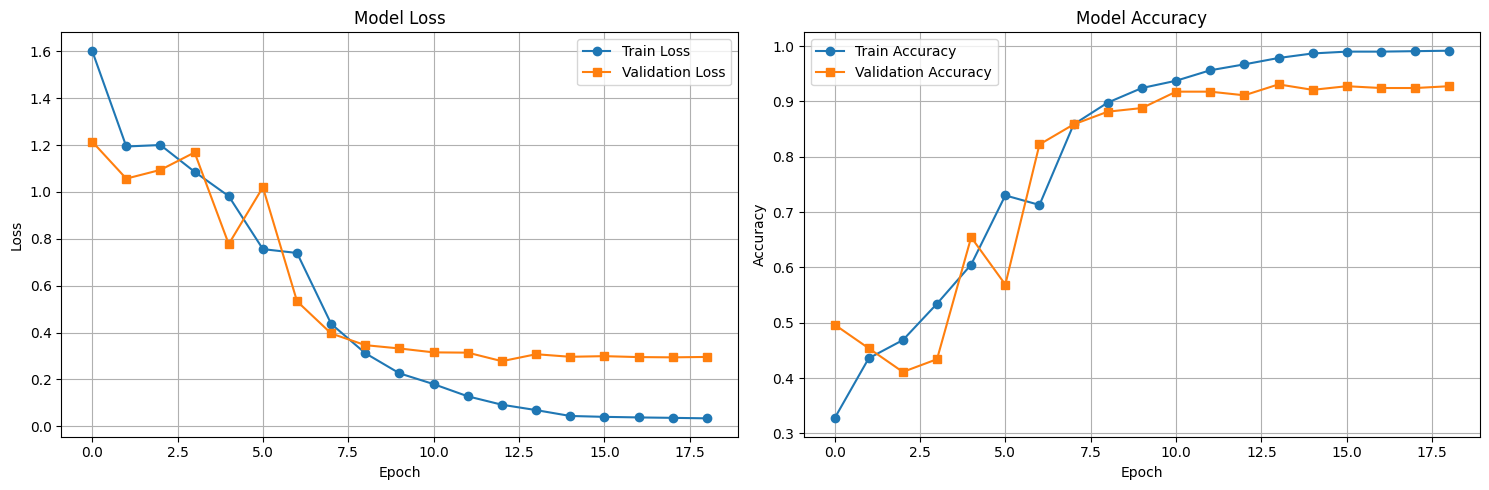

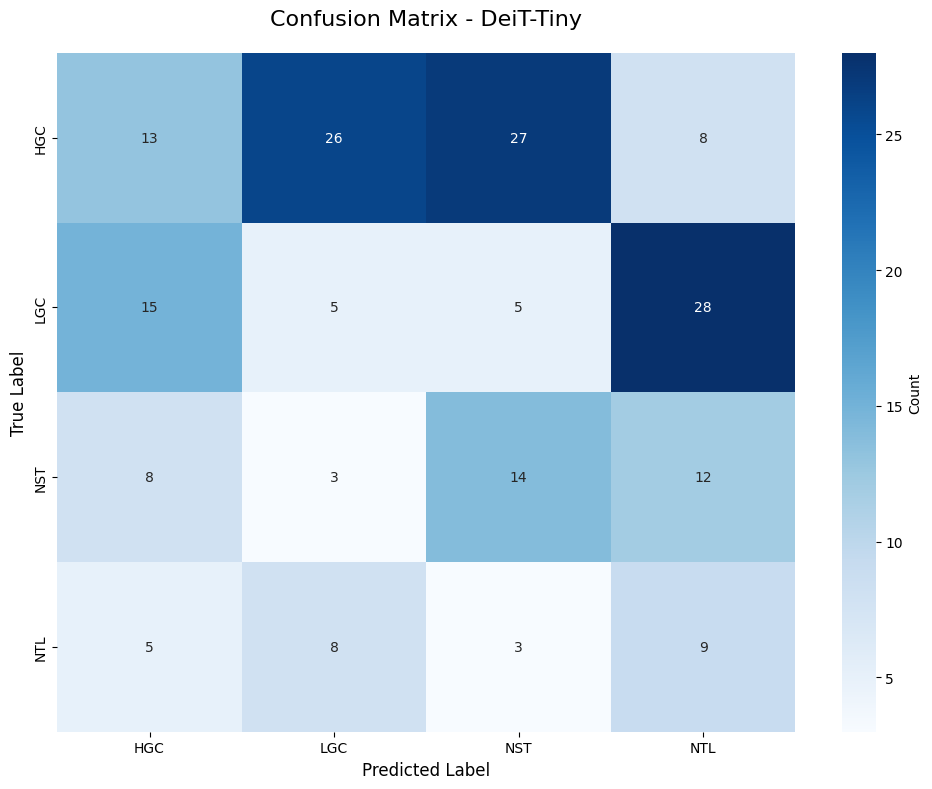

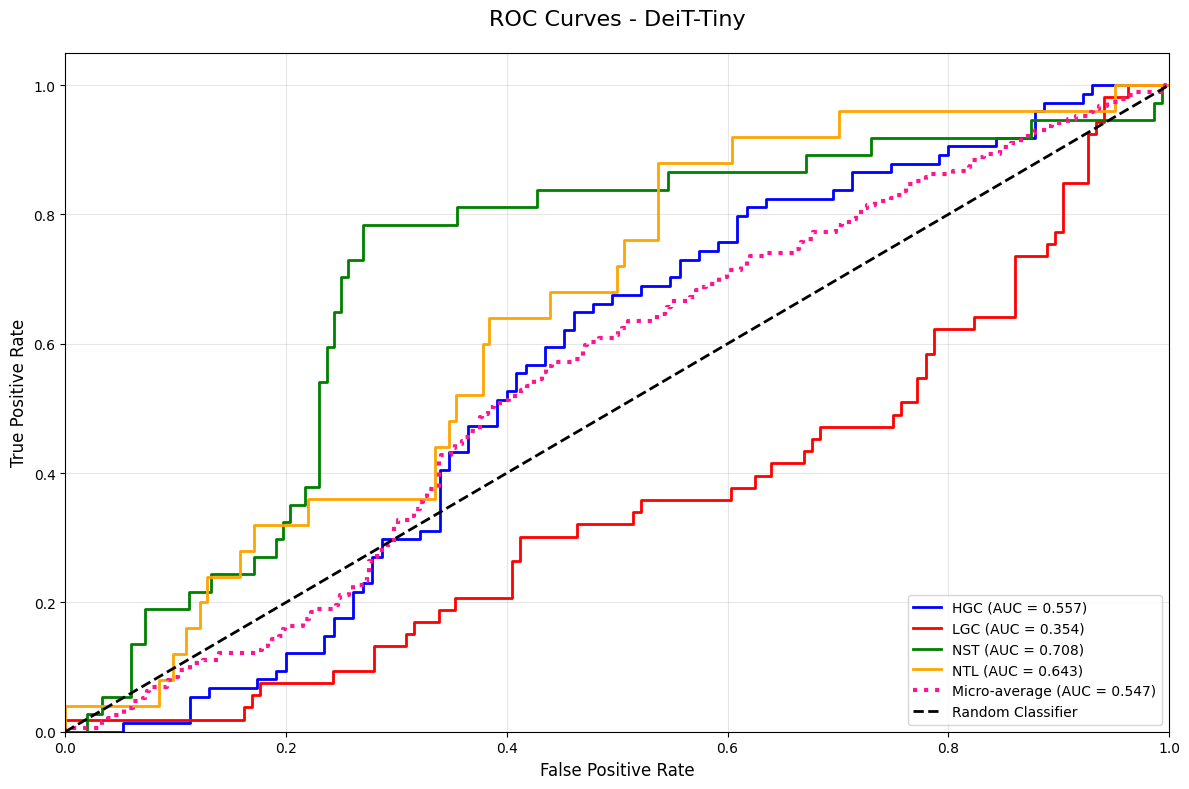


DeiT-Tiny training and evaluation complete!


In [16]:
print("="  * 80)
print("Training DeiT Tiny with Imaging Type")
print("=" * 80)

# Create model
deit_tiny = create_deit_model(architecture='deit_tiny_patch16_224', num_classes=4, num_imaging_types=2, pretrained=True)

# Create trainer
trainer_deit_tiny = ModelTrainer(deit_tiny, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_deit_tiny = trainer_deit_tiny.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="DeiT-Tiny_with_ImagingType")

# Plot training history
trainer_deit_tiny.plot_training_history(save_path='deit_tiny_training_history.png')

# Evaluate model
results_deit_tiny = trainer_deit_tiny.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_deit_tiny['confusion_matrix'], class_names, 'DeiT-Tiny',
                      save_path='deit_tiny_confusion_matrix.png')

# Plot ROC curves
roc_auc_deit_tiny = plot_roc_curves(results_deit_tiny['labels'], results_deit_tiny['probabilities'], class_names, 'DeiT-Tiny',
                                     save_path='deit_tiny_roc_curves.png')

# Store results
results_deit_tiny['model_name'] = 'DeiT-Tiny'
results_deit_tiny['roc_auc'] = roc_auc_deit_tiny
all_results.append(results_deit_tiny)

print("\nDeiT-Tiny training and evaluation complete!")

## Train DeiT Small

Training DeiT Small with Imaging Type


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.92it/s, Loss=1.4440, Acc=0.2944]


Train Loss: 1.4440 Acc: 0.2944 Macro-F1: 0.2850


Val : 100%|██████████| 10/10 [00:01<00:00,  8.97it/s, Loss=1.3212, Acc=0.3158]


Val Loss: 1.3212 Acc: 0.3158 Macro-F1: 0.2061
✓ New best model saved with validation macro-F1: 0.2061

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.94it/s, Loss=1.2297, Acc=0.3914]


Train Loss: 1.2297 Acc: 0.3914 Macro-F1: 0.3588


Val : 100%|██████████| 10/10 [00:01<00:00,  8.71it/s, Loss=1.2754, Acc=0.4211]


Val Loss: 1.2754 Acc: 0.4211 Macro-F1: 0.3315
✓ New best model saved with validation macro-F1: 0.3315

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.94it/s, Loss=1.1828, Acc=0.4720]


Train Loss: 1.1828 Acc: 0.4720 Macro-F1: 0.4421


Val : 100%|██████████| 10/10 [00:01<00:00,  8.20it/s, Loss=1.0490, Acc=0.6151]


Val Loss: 1.0490 Acc: 0.6151 Macro-F1: 0.5706
✓ New best model saved with validation macro-F1: 0.5706

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.92it/s, Loss=1.0299, Acc=0.5691]


Train Loss: 1.0299 Acc: 0.5691 Macro-F1: 0.5249


Val : 100%|██████████| 10/10 [00:01<00:00,  8.72it/s, Loss=1.0066, Acc=0.5658]


Val Loss: 1.0066 Acc: 0.5658 Macro-F1: 0.5658

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.91it/s, Loss=0.9334, Acc=0.6250]


Train Loss: 0.9334 Acc: 0.6250 Macro-F1: 0.5834


Val : 100%|██████████| 10/10 [00:01<00:00,  8.95it/s, Loss=0.8559, Acc=0.5921]


Val Loss: 0.8559 Acc: 0.5921 Macro-F1: 0.5626

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.95it/s, Loss=0.7171, Acc=0.7319]


Train Loss: 0.7171 Acc: 0.7319 Macro-F1: 0.6941


Val : 100%|██████████| 10/10 [00:01<00:00,  8.94it/s, Loss=0.7063, Acc=0.7500]


Val Loss: 0.7063 Acc: 0.7500 Macro-F1: 0.7245
✓ New best model saved with validation macro-F1: 0.7245

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.91it/s, Loss=0.6444, Acc=0.7393]


Train Loss: 0.6444 Acc: 0.7393 Macro-F1: 0.7142


Val : 100%|██████████| 10/10 [00:01<00:00,  9.03it/s, Loss=0.6695, Acc=0.7599]


Val Loss: 0.6695 Acc: 0.7599 Macro-F1: 0.7171

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.94it/s, Loss=0.4531, Acc=0.8553]


Train Loss: 0.4531 Acc: 0.8553 Macro-F1: 0.8384


Val : 100%|██████████| 10/10 [00:01<00:00,  9.14it/s, Loss=0.4321, Acc=0.8322]


Val Loss: 0.4321 Acc: 0.8322 Macro-F1: 0.8107
✓ New best model saved with validation macro-F1: 0.8107

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.92it/s, Loss=0.3222, Acc=0.8980]


Train Loss: 0.3222 Acc: 0.8980 Macro-F1: 0.8896


Val : 100%|██████████| 10/10 [00:01<00:00,  8.96it/s, Loss=0.3865, Acc=0.8783]


Val Loss: 0.3865 Acc: 0.8783 Macro-F1: 0.8489
✓ New best model saved with validation macro-F1: 0.8489

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.96it/s, Loss=0.2519, Acc=0.9202]


Train Loss: 0.2519 Acc: 0.9202 Macro-F1: 0.9093


Val : 100%|██████████| 10/10 [00:01<00:00,  8.84it/s, Loss=0.3474, Acc=0.8882]


Val Loss: 0.3474 Acc: 0.8882 Macro-F1: 0.8673
✓ New best model saved with validation macro-F1: 0.8673

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.97it/s, Loss=0.1920, Acc=0.9367]


Train Loss: 0.1920 Acc: 0.9367 Macro-F1: 0.9346


Val : 100%|██████████| 10/10 [00:01<00:00,  9.01it/s, Loss=0.3380, Acc=0.8914]


Val Loss: 0.3380 Acc: 0.8914 Macro-F1: 0.8751
✓ New best model saved with validation macro-F1: 0.8751

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.93it/s, Loss=0.1428, Acc=0.9572]


Train Loss: 0.1428 Acc: 0.9572 Macro-F1: 0.9542


Val : 100%|██████████| 10/10 [00:01<00:00,  8.98it/s, Loss=0.3186, Acc=0.9145]


Val Loss: 0.3186 Acc: 0.9145 Macro-F1: 0.9017
✓ New best model saved with validation macro-F1: 0.9017

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.93it/s, Loss=0.1034, Acc=0.9663]


Train Loss: 0.1034 Acc: 0.9663 Macro-F1: 0.9601


Val : 100%|██████████| 10/10 [00:01<00:00,  8.62it/s, Loss=0.3279, Acc=0.8914]


Val Loss: 0.3279 Acc: 0.8914 Macro-F1: 0.8769

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.93it/s, Loss=0.1011, Acc=0.9704]


Train Loss: 0.1011 Acc: 0.9704 Macro-F1: 0.9660


Val : 100%|██████████| 10/10 [00:01<00:00,  8.93it/s, Loss=0.3251, Acc=0.8947]


Val Loss: 0.3251 Acc: 0.8947 Macro-F1: 0.8810

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.91it/s, Loss=0.0566, Acc=0.9827]


Train Loss: 0.0566 Acc: 0.9827 Macro-F1: 0.9829


Val : 100%|██████████| 10/10 [00:01<00:00,  9.14it/s, Loss=0.3028, Acc=0.9046]


Val Loss: 0.3028 Acc: 0.9046 Macro-F1: 0.8869

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.94it/s, Loss=0.0472, Acc=0.9901]


Train Loss: 0.0472 Acc: 0.9901 Macro-F1: 0.9900


Val : 100%|██████████| 10/10 [00:01<00:00,  9.01it/s, Loss=0.3031, Acc=0.9046]


Val Loss: 0.3031 Acc: 0.9046 Macro-F1: 0.8890

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.93it/s, Loss=0.0436, Acc=0.9910]


Train Loss: 0.0436 Acc: 0.9910 Macro-F1: 0.9906


Val : 100%|██████████| 10/10 [00:01<00:00,  8.79it/s, Loss=0.3029, Acc=0.9079]


Val Loss: 0.3029 Acc: 0.9079 Macro-F1: 0.8917
Early stopping triggered after 17 epochs
Training complete in 2m 32s
Best validation macro-F1: 0.9017
Evaluating on test set...


100%|██████████| 6/6 [00:00<00:00,  6.99it/s]


Test Accuracy: 26.98%
Test Loss: 3.8031

Classification Report:
              precision    recall  f1-score   support

         HGC       0.28      0.18      0.22        74
         LGC       0.21      0.26      0.23        53
         NST       0.31      0.35      0.33        37
         NTL       0.32      0.44      0.37        25

    accuracy                           0.27       189
   macro avg       0.28      0.31      0.29       189
weighted avg       0.27      0.27      0.26       189


Confusion Matrix:
[[13 32 27  2]
 [25 14  2 12]
 [ 5 10 13  9]
 [ 3 11  0 11]]

ROC-AUC Scores:
Macro-average AUC: 0.5727
Micro-average AUC: 0.5645
HGC AUC: 0.5009
LGC AUC: 0.4641
NST AUC: 0.6314
NTL AUC: 0.6944


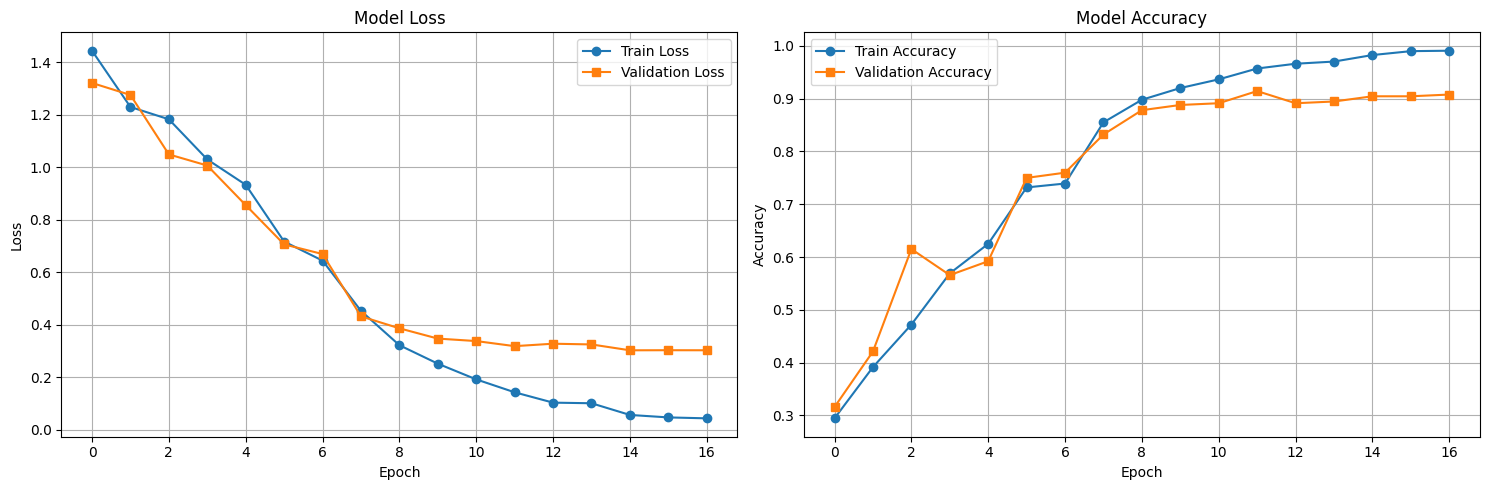

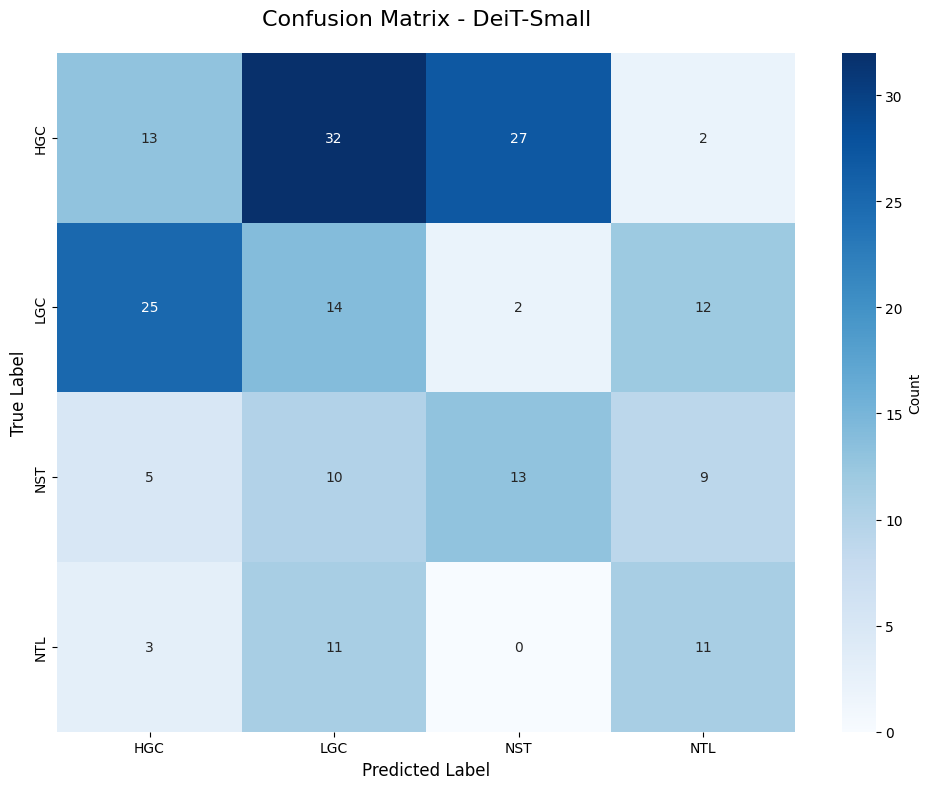

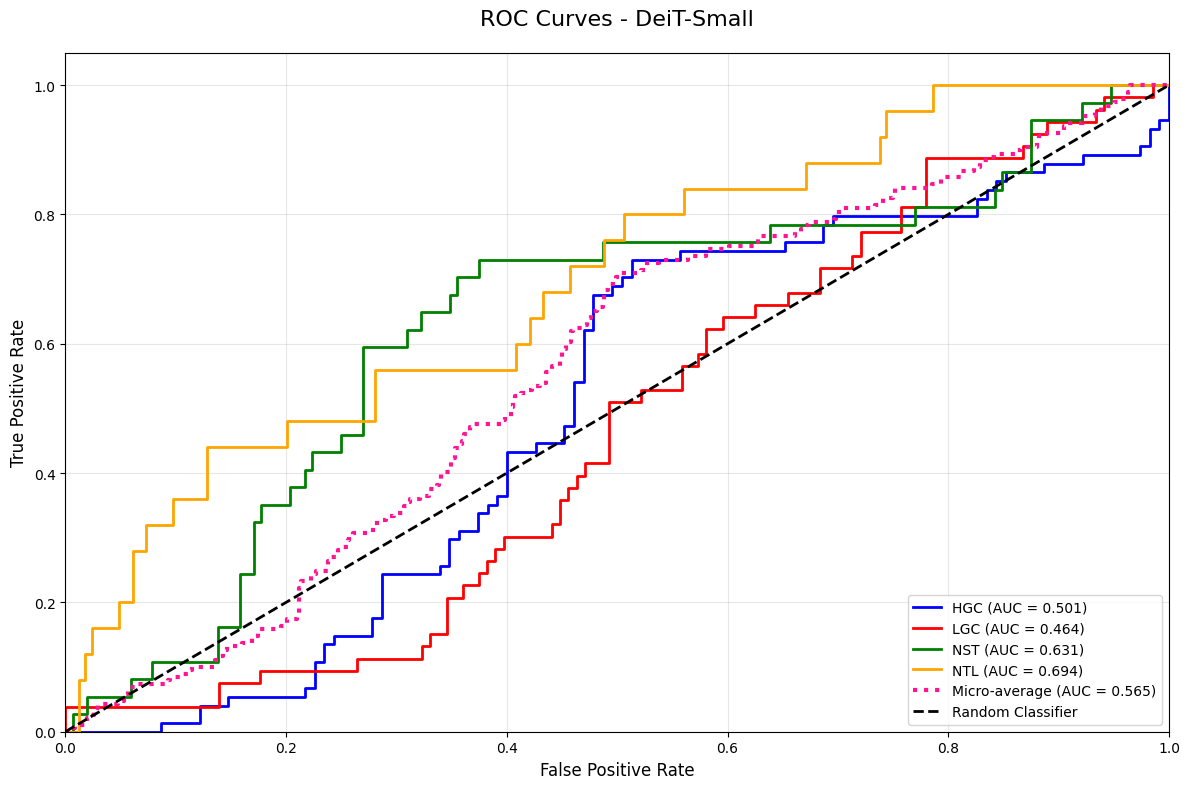


DeiT-Small training and evaluation complete!


In [17]:
print("=" * 80)
print("Training DeiT Small with Imaging Type")
print("=" * 80)

# Create model
deit_small = create_deit_model(architecture='deit_small_patch16_224', num_classes=4, num_imaging_types=2, pretrained=True)

# Create trainer
trainer_deit_small = ModelTrainer(deit_small, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_deit_small = trainer_deit_small.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="DeiT-Small_with_ImagingType")

# Plot training history
trainer_deit_small.plot_training_history(save_path='deit_small_training_history.png')

# Evaluate model
results_deit_small = trainer_deit_small.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_deit_small['confusion_matrix'], class_names, 'DeiT-Small',
                      save_path='deit_small_confusion_matrix.png')

# Plot ROC curves
roc_auc_deit_small = plot_roc_curves(results_deit_small['labels'], results_deit_small['probabilities'], class_names, 'DeiT-Small',
                                     save_path='deit_small_roc_curves.png')

# Store results
results_deit_small['model_name'] = 'DeiT-Small'
results_deit_small['roc_auc'] = roc_auc_deit_small
all_results.append(results_deit_small)

print("\nDeiT-Small training and evaluation complete!")

## Train DeiT Base

Training DeiT Base with Imaging Type


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.66it/s, Loss=1.4656, Acc=0.2599]


Train Loss: 1.4656 Acc: 0.2599 Macro-F1: 0.2421


Val : 100%|██████████| 10/10 [00:02<00:00,  4.29it/s, Loss=1.4512, Acc=0.0855]


Val Loss: 1.4512 Acc: 0.0855 Macro-F1: 0.0514
✓ New best model saved with validation macro-F1: 0.0514

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.66it/s, Loss=1.3757, Acc=0.3174]


Train Loss: 1.3757 Acc: 0.3174 Macro-F1: 0.2886


Val : 100%|██████████| 10/10 [00:02<00:00,  4.37it/s, Loss=1.2816, Acc=0.3355]


Val Loss: 1.2816 Acc: 0.3355 Macro-F1: 0.2065
✓ New best model saved with validation macro-F1: 0.2065

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.66it/s, Loss=1.2565, Acc=0.4137]


Train Loss: 1.2565 Acc: 0.4137 Macro-F1: 0.3622


Val : 100%|██████████| 10/10 [00:02<00:00,  4.38it/s, Loss=1.1564, Acc=0.4342]


Val Loss: 1.1564 Acc: 0.4342 Macro-F1: 0.4386
✓ New best model saved with validation macro-F1: 0.4386

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.66it/s, Loss=1.2207, Acc=0.4301]


Train Loss: 1.2207 Acc: 0.4301 Macro-F1: 0.3948


Val : 100%|██████████| 10/10 [00:02<00:00,  4.41it/s, Loss=1.0775, Acc=0.4901]


Val Loss: 1.0775 Acc: 0.4901 Macro-F1: 0.4346

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.66it/s, Loss=1.1021, Acc=0.4885]


Train Loss: 1.1021 Acc: 0.4885 Macro-F1: 0.4486


Val : 100%|██████████| 10/10 [00:02<00:00,  4.42it/s, Loss=1.0717, Acc=0.5789]


Val Loss: 1.0717 Acc: 0.5789 Macro-F1: 0.4215

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.66it/s, Loss=1.1083, Acc=0.5238]


Train Loss: 1.1083 Acc: 0.5238 Macro-F1: 0.4713


Val : 100%|██████████| 10/10 [00:02<00:00,  4.33it/s, Loss=1.0456, Acc=0.4737]


Val Loss: 1.0456 Acc: 0.4737 Macro-F1: 0.4293

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.66it/s, Loss=1.1494, Acc=0.4926]


Train Loss: 1.1494 Acc: 0.4926 Macro-F1: 0.4470


Val : 100%|██████████| 10/10 [00:02<00:00,  4.43it/s, Loss=1.0917, Acc=0.5757]


Val Loss: 1.0917 Acc: 0.5757 Macro-F1: 0.4892
✓ New best model saved with validation macro-F1: 0.4892

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.66it/s, Loss=0.9607, Acc=0.6036]


Train Loss: 0.9607 Acc: 0.6036 Macro-F1: 0.5388


Val : 100%|██████████| 10/10 [00:02<00:00,  4.25it/s, Loss=0.8357, Acc=0.6382]


Val Loss: 0.8357 Acc: 0.6382 Macro-F1: 0.5794
✓ New best model saved with validation macro-F1: 0.5794

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.66it/s, Loss=0.8157, Acc=0.6579]


Train Loss: 0.8157 Acc: 0.6579 Macro-F1: 0.6203


Val : 100%|██████████| 10/10 [00:02<00:00,  4.43it/s, Loss=0.7913, Acc=0.6645]


Val Loss: 0.7913 Acc: 0.6645 Macro-F1: 0.6294
✓ New best model saved with validation macro-F1: 0.6294

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.66it/s, Loss=0.7699, Acc=0.6694]


Train Loss: 0.7699 Acc: 0.6694 Macro-F1: 0.6453


Val : 100%|██████████| 10/10 [00:02<00:00,  4.40it/s, Loss=0.7471, Acc=0.6579]


Val Loss: 0.7471 Acc: 0.6579 Macro-F1: 0.6186

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.66it/s, Loss=0.7264, Acc=0.6768]


Train Loss: 0.7264 Acc: 0.6768 Macro-F1: 0.6406


Val : 100%|██████████| 10/10 [00:02<00:00,  4.36it/s, Loss=0.7063, Acc=0.7039]


Val Loss: 0.7063 Acc: 0.7039 Macro-F1: 0.6568
✓ New best model saved with validation macro-F1: 0.6568

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.66it/s, Loss=0.6715, Acc=0.6924]


Train Loss: 0.6715 Acc: 0.6924 Macro-F1: 0.6662


Val : 100%|██████████| 10/10 [00:02<00:00,  4.40it/s, Loss=0.6950, Acc=0.7138]


Val Loss: 0.6950 Acc: 0.7138 Macro-F1: 0.6550

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.66it/s, Loss=0.6512, Acc=0.7072]


Train Loss: 0.6512 Acc: 0.7072 Macro-F1: 0.6896


Val : 100%|██████████| 10/10 [00:02<00:00,  4.40it/s, Loss=0.7120, Acc=0.7105]


Val Loss: 0.7120 Acc: 0.7105 Macro-F1: 0.6702
✓ New best model saved with validation macro-F1: 0.6702

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.66it/s, Loss=0.6265, Acc=0.7212]


Train Loss: 0.6265 Acc: 0.7212 Macro-F1: 0.7058


Val : 100%|██████████| 10/10 [00:02<00:00,  4.45it/s, Loss=0.7279, Acc=0.6743]


Val Loss: 0.7279 Acc: 0.6743 Macro-F1: 0.6414

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.66it/s, Loss=0.5671, Acc=0.7056]


Train Loss: 0.5671 Acc: 0.7056 Macro-F1: 0.6934


Val : 100%|██████████| 10/10 [00:02<00:00,  4.41it/s, Loss=0.6223, Acc=0.7336]


Val Loss: 0.6223 Acc: 0.7336 Macro-F1: 0.7097
✓ New best model saved with validation macro-F1: 0.7097

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.66it/s, Loss=0.5175, Acc=0.7607]


Train Loss: 0.5175 Acc: 0.7607 Macro-F1: 0.7565


Val : 100%|██████████| 10/10 [00:02<00:00,  4.39it/s, Loss=0.6072, Acc=0.7434]


Val Loss: 0.6072 Acc: 0.7434 Macro-F1: 0.7224
✓ New best model saved with validation macro-F1: 0.7224

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.66it/s, Loss=0.5048, Acc=0.7623]


Train Loss: 0.5048 Acc: 0.7623 Macro-F1: 0.7597


Val : 100%|██████████| 10/10 [00:02<00:00,  4.34it/s, Loss=0.6135, Acc=0.7401]


Val Loss: 0.6135 Acc: 0.7401 Macro-F1: 0.7149

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.66it/s, Loss=0.4933, Acc=0.7722]


Train Loss: 0.4933 Acc: 0.7722 Macro-F1: 0.7780


Val : 100%|██████████| 10/10 [00:02<00:00,  4.36it/s, Loss=0.6211, Acc=0.7368]


Val Loss: 0.6211 Acc: 0.7368 Macro-F1: 0.7137

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.66it/s, Loss=0.4834, Acc=0.7730]


Train Loss: 0.4834 Acc: 0.7730 Macro-F1: 0.7764


Val : 100%|██████████| 10/10 [00:02<00:00,  4.36it/s, Loss=0.6048, Acc=0.7533]


Val Loss: 0.6048 Acc: 0.7533 Macro-F1: 0.7375
✓ New best model saved with validation macro-F1: 0.7375

Epoch 20/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.67it/s, Loss=0.4762, Acc=0.7829]


Train Loss: 0.4762 Acc: 0.7829 Macro-F1: 0.7847


Val : 100%|██████████| 10/10 [00:02<00:00,  4.36it/s, Loss=0.6161, Acc=0.7401]


Val Loss: 0.6161 Acc: 0.7401 Macro-F1: 0.7160

Epoch 21/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.66it/s, Loss=0.4612, Acc=0.7796]


Train Loss: 0.4612 Acc: 0.7796 Macro-F1: 0.7840


Val : 100%|██████████| 10/10 [00:02<00:00,  4.36it/s, Loss=0.6057, Acc=0.7500]


Val Loss: 0.6057 Acc: 0.7500 Macro-F1: 0.7371

Epoch 22/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.66it/s, Loss=0.4613, Acc=0.7812]


Train Loss: 0.4613 Acc: 0.7812 Macro-F1: 0.7872


Val : 100%|██████████| 10/10 [00:02<00:00,  4.40it/s, Loss=0.6095, Acc=0.7500]


Val Loss: 0.6095 Acc: 0.7500 Macro-F1: 0.7341

Epoch 23/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.66it/s, Loss=0.4555, Acc=0.7821]


Train Loss: 0.4555 Acc: 0.7821 Macro-F1: 0.7861


Val : 100%|██████████| 10/10 [00:02<00:00,  4.40it/s, Loss=0.6124, Acc=0.7467]


Val Loss: 0.6124 Acc: 0.7467 Macro-F1: 0.7245

Epoch 24/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.66it/s, Loss=0.4558, Acc=0.7845]


Train Loss: 0.4558 Acc: 0.7845 Macro-F1: 0.7873


Val : 100%|██████████| 10/10 [00:02<00:00,  4.37it/s, Loss=0.6130, Acc=0.7467]


Val Loss: 0.6130 Acc: 0.7467 Macro-F1: 0.7245
Early stopping triggered after 24 epochs
Training complete in 10m 11s
Best validation macro-F1: 0.7375
Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  3.73it/s]


Test Accuracy: 14.29%
Test Loss: 3.0931

Classification Report:
              precision    recall  f1-score   support

         HGC       0.41      0.15      0.22        74
         LGC       0.04      0.04      0.04        53
         NST       0.09      0.11      0.10        37
         NTL       0.14      0.40      0.20        25

    accuracy                           0.14       189
   macro avg       0.17      0.17      0.14       189
weighted avg       0.21      0.14      0.14       189


Confusion Matrix:
[[11 28 35  0]
 [12  2  5 34]
 [ 1  3  4 29]
 [ 3 12  0 10]]

ROC-AUC Scores:
Macro-average AUC: 0.4994
Micro-average AUC: 0.4552
HGC AUC: 0.4100
LGC AUC: 0.4704
NST AUC: 0.5845
NTL AUC: 0.5327


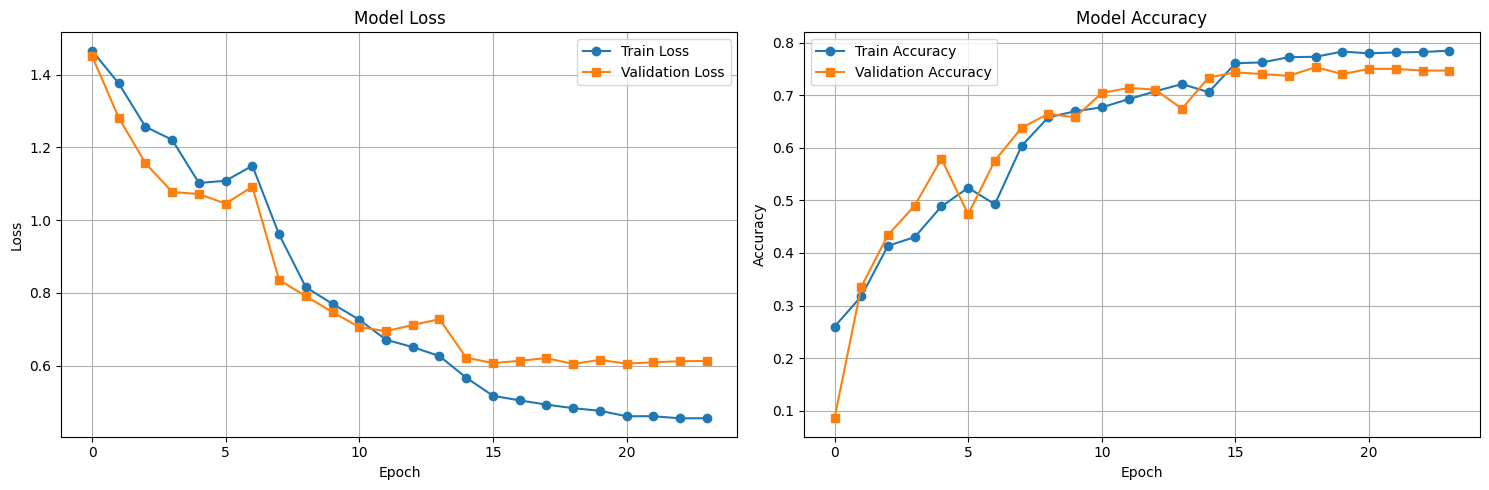

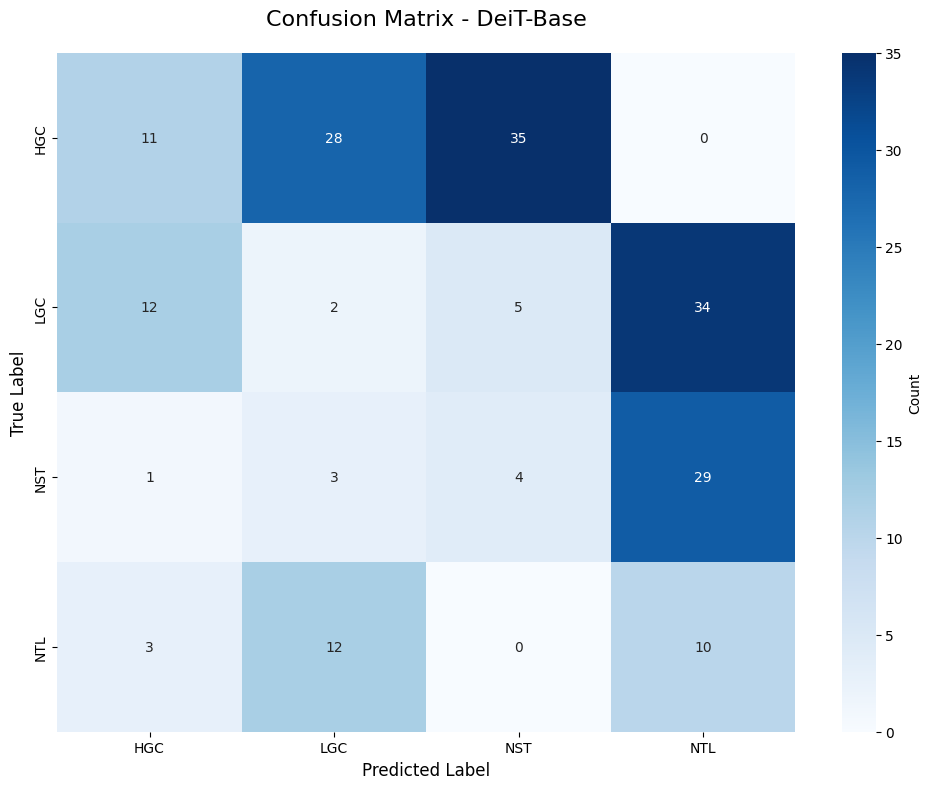

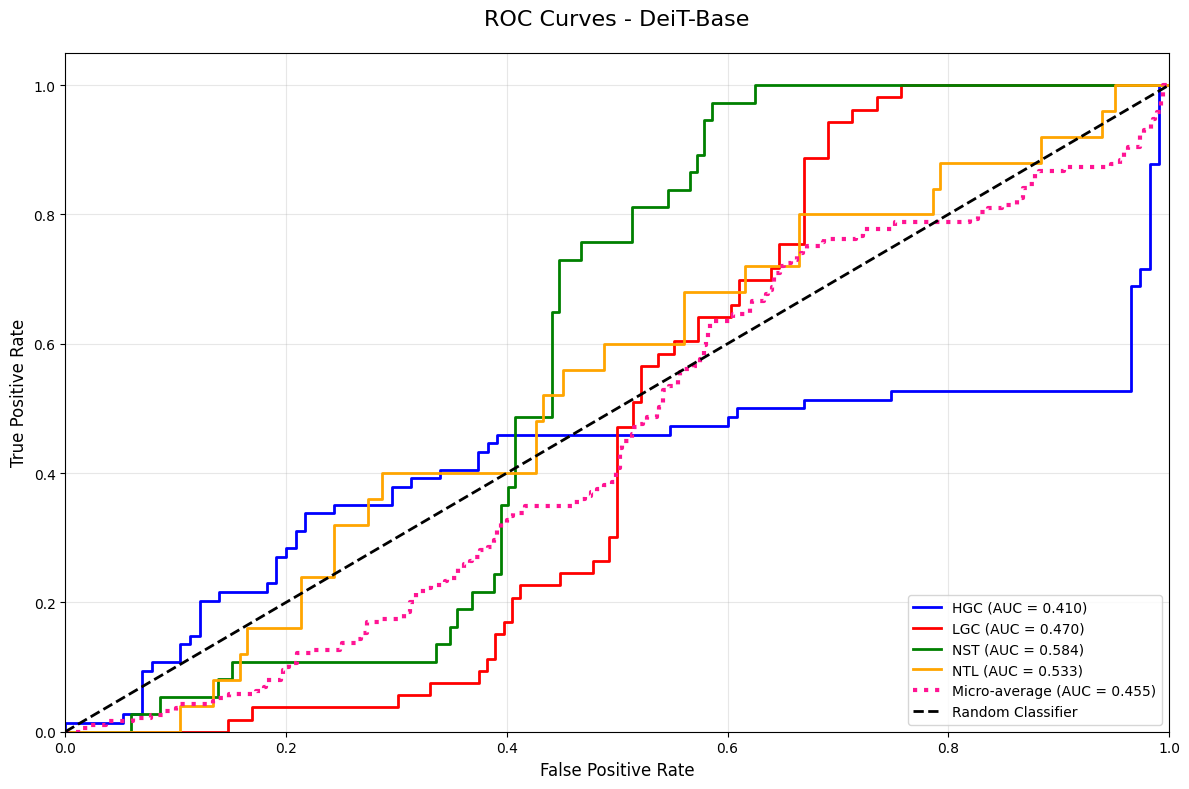


DeiT-Base training and evaluation complete!


In [18]:
print("=" * 80)
print("Training DeiT Base with Imaging Type")
print("=" * 80)

# Create model
deit_base = create_deit_model(architecture='deit_base_patch16_224', num_classes=4, num_imaging_types=2, pretrained=True)

# Create trainer
trainer_deit_base = ModelTrainer(deit_base, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_deit_base = trainer_deit_base.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="DeiT-Base_with_ImagingType")

# Plot training history
trainer_deit_base.plot_training_history(save_path='deit_base_training_history.png')

# Evaluate model
results_deit_base = trainer_deit_base.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_deit_base['confusion_matrix'], class_names, 'DeiT-Base',
                      save_path='deit_base_confusion_matrix.png')

# Plot ROC curves
roc_auc_deit_base = plot_roc_curves(results_deit_base['labels'], results_deit_base['probabilities'], class_names, 'DeiT-Base',
                                     save_path='deit_base_roc_curves.png')

# Store results
results_deit_base['model_name'] = 'DeiT-Base'
results_deit_base['roc_auc'] = roc_auc_deit_base
all_results.append(results_deit_base)

print("\nDeiT-Base training and evaluation complete!")

# Save All Metrics to CSV

In [19]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'DeiT_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())


Metrics saved to: DeiT_metrics.csv

Metrics Summary:
        Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0   DeiT-Tiny         21.693122      4.546722             0.219932          0.252098      0.219111                0.234348             0.216931         0.210813       0.317073    0.175676  0.226087         74.0       0.119048    0.094340  0.105263         53.0       0.285714    0.378378  0.325581         37.0       0.157895        0.36  0.219512         25.0   0.565416   0.546644  0.557109  0.353635  0.707504  0.643415      0.557109      0.353